In [1]:
!pip install gunpowder

  Using cached gunpowder-1.2.2-py3-none-any.whl (151 kB)
  Using cached h5py-3.7.0-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (4.5 MB)
  Using cached augment_nd-0.1.2-py3-none-any.whl (5.2 kB)
     |████████████████████████████████| 14.0 MB 3.9 MB/s eta 0:00:01
  Using cached packaging-21.3-py3-none-any.whl (40 kB)
  Using cached tifffile-2022.8.12-py3-none-any.whl (208 kB)
     |████████████████████████████████| 6.9 MB 75.3 MB/s eta 0:00:01
  Using cached networkx-2.8.6-py3-none-any.whl (2.0 MB)
     |████████████████████████████████| 3.1 MB 80.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.4 MB 91.3 MB/s eta 0:00:01
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)


In [3]:
!pip install gunpowder
!pip install zarr
!pip install matplotlib

     |████████████████████████████████| 185 kB 4.5 MB/s eta 0:00:01
     |████████████████████████████████| 6.7 MB 29.0 MB/s eta 0:00:01
  Using cached entrypoints-0.4-py3-none-any.whl (5.3 kB)
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5050 sha256=131bacd9860e3ced5ae9219f74c80a378a9a0081e6001289c49e624c45f95868
  Stored in directory: /home/llanosp/.cache/pip/wheels/07/00/bc/937e878be0d781a569792a1e0e5acf149e463d4536453ec978
Successfully built asciitree
  Using cached matplotlib-3.5.3-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached fonttools-4.37.1-py3-none-any.whl (957 kB)
     |████████████████████████████████| 1.6 MB 4.5 MB/s eta 0:00:01
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import random
import zarr
from skimage import data
from skimage import filters

# make sure we all see the same
np.random.seed(19623)
random.seed(19623)

# open a sample image (channels first)
raw_data2 = data.astronaut().transpose(2, 0, 1)

import skimage.io as sk

raw_data = sk.imread("celegans/01/t000.tif", plugin="tifffile")

ModuleNotFoundError: No module named 'zarr'

In [ ]:
imstack1.shape

In [62]:

# create some dummy "ground-truth" to train on
gt_data = filters.gaussian(raw_data[0], sigma=3.0) > 0.75
gt_data = gt_data[np.newaxis,:].astype(np.float32)

# store image in zarr container
f = zarr.open('sample_data.zarr', 'w')
f['raw'] = raw_data
f['raw'].attrs['resolution'] = (1, 1, 1)
f['ground_truth'] = gt_data
f['ground_truth'].attrs['resolution'] = (1, 1, 1)

# helper function to show image(s), channels first
def imshow(raw, ground_truth=None, prediction=None):
  rows = 1
  if ground_truth is not None:
    rows += 1
  if prediction is not None:
    rows += 1
  cols = raw.shape[0] if len(raw.shape) > 3 else 1
  fig, axes = plt.subplots(rows, cols, figsize=(10, 4), sharex=True, sharey=True, squeeze=False)
  if len(raw.shape) == 3:
    axes[0][0].imshow(raw.transpose(1, 2, 0))
  else:
    for i, im in enumerate(raw):
      axes[0][i].imshow(im.transpose(1, 2, 0))
  row = 1
  if ground_truth is not None:
    if len(ground_truth.shape) == 3:
      axes[row][0].imshow(ground_truth[0])
    else:
      for i, gt in enumerate(ground_truth):
        axes[row][i].imshow(gt[0])
    row += 1
  if prediction is not None:
    if len(prediction.shape) == 3:
      axes[row][0].imshow(prediction[0])
    else:
      for i, gt in enumerate(prediction):
        axes[row][i].imshow(gt[0])
  plt.show()

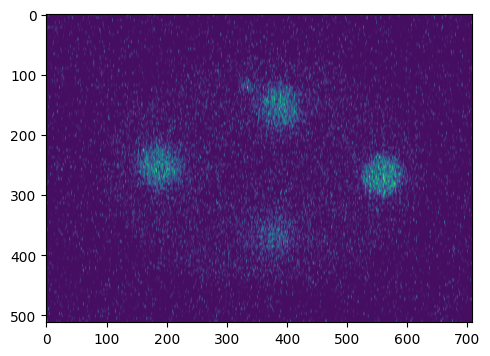

In [63]:
n = 19
imshow(zarr.open('sample_data.zarr')['raw'][n:n+1])

In [64]:
import gunpowder as gp

# declare arrays to use in the pipeline
raw = gp.ArrayKey('RAW')


In [65]:
import warnings
warnings.filterwarnings('ignore')

In [66]:
# create "pipeline" consisting only of a data source
source = gp.ZarrSource(
    'sample_data.zarr',  # the zarr container
    {raw: 'raw'},  # which dataset to associate to the array key
    {raw: gp.ArraySpec(interpolatable=True)}  # meta-information
)
pipeline = source

In [67]:
pipeline

ZarrSource[sample_data.zarr], providing: None

In [68]:
# formulate a request for "raw"
request = gp.BatchRequest()
request[raw] = gp.Roi((0, 0, 0), (4, 127, 176))

In [69]:
raw_data.shape

(35, 512, 708)

In [70]:
request[raw]

ROI: [0:4, 0:127, 0:176] (4, 127, 176), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False

In [71]:
gp.Roi?

Init signature: gp.Roi(offset=None, shape=None)
Docstring:     
A rectangular region of interest, defined by an offset and a shape.

Similar to :class:`Coordinate`, supports simple arithmetics, e.g.::

    roi = Roi((1, 1, 1), (10, 10, 10))
    voxel_size = Coordinate((10, 5, 1))
    scale_shift = roi*voxel_size + 1 # == Roi((11, 6, 2), (101, 51, 11))

Args:

    offset (array-like of ``int``, optional):

        The starting point (inclusive) of the ROI. Can be ``None``
        (default) if the ROI only characterizes a shape.

    shape (array-like):

        The shape of the ROI. Entries can be ``None`` to indicate
        unboundedness. If ``None`` is passed instead of a tuple, all
        dimensions are set to ``None``, if the number of dimensions can be
        inferred from ``offset``.
File:           ~/miniconda3/envs/exercise08_v2/lib/python3.9/site-packages/gunpowder/roi.py
Type:           type
Subclasses:     


In [72]:
batch


	RAW: ROI: [0:128, 0:512] (128, 512), voxel size: (1, 1), interpolatable: True, non-spatial: False, dtype: uint8, placeholder: False

batch returned: 
	RAW: ROI: [0:4, 0:127, 0:176] (4, 127, 176), voxel size: (1, 1, 1), interpolatable: True, non-spatial: False, dtype: uint8, placeholder: False



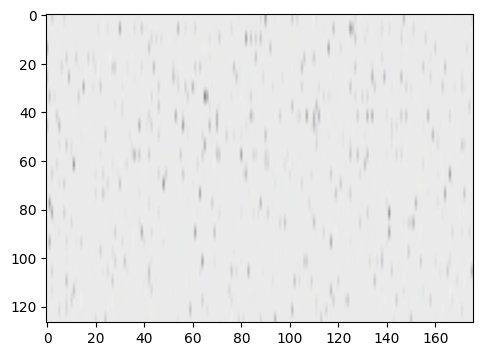

In [74]:
# build the pipeline...
with gp.build(pipeline):

  # ...and request a batch
  batch = pipeline.request_batch(request)

# show the content of the batch
print(f"batch returned: {batch}")
imshow(batch[raw].data)

In [75]:
random_location = gp.RandomLocation()
pipeline = source + random_location

print(pipeline)


ZarrSource[sample_data.zarr] -> RandomLocation


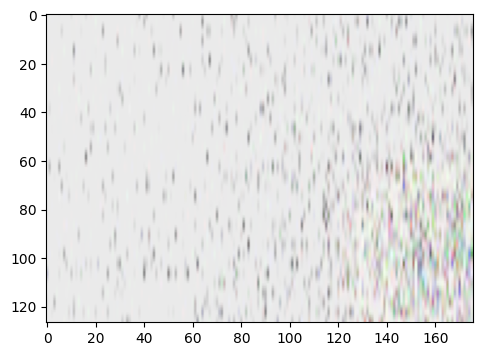

In [76]:
with gp.build(pipeline):
  batch = pipeline.request_batch(request)

imshow(batch[raw].data)

### GEOMETRICAL AUGMENTATION

### Simple Augmentation

In [79]:
simple_augment = gp.SimpleAugment()
pipeline = source + random_location + simple_augment

with gp.build(pipeline):
    batch = pipeline.request_batch(request)

#imshow(batch[raw].data)

In [84]:
import math

elastic_augment = gp.ElasticAugment(
    [4,40,40],
    [0,2,2],
    [0,math.pi/2.0],
    prob_slip=0.05,
    prob_shift=0.05,
    max_misalign=25)

pipeline = source + random_location + simple_augment + elastic_augment

with gp.build(pipeline):
    batch = pipeline.request_batch(request)

#imshow(batch[raw].data)


#### Simple Augmentation

In [ ]:
#gp.SimpleAugment(transpose_only=[1, 2])

In [ ]:
# scale and shift the intensity of the raw array

In [85]:
Intensity_augment=gp.IntensityAugment(
                    raw,
                    scale_min=0.9,
                    scale_max=1.1,
                    shift_min=-0.1,
                    shift_max=0.1,
                    z_section_wise=True) 

In [ ]:
Augmentations=
# chose a random source (i.e., sample) from the above
Augmentations=gp.RandomProvider() +

# elastically deform the batch
gp.ElasticAugment(
    [4,40,40],
    [0,2,2],
    [0,math.pi/2.0],
    prob_slip=0.05,
    prob_shift=0.05,
    max_misalign=25) +

# apply transpose and mirror augmentations
gp.SimpleAugment(transpose_only=[1, 2]) +

# scale and shift the intensity of the raw array
gp.IntensityAugment(
    raw,
    scale_min=0.9,
    scale_max=1.1,
    shift_min=-0.1,
    shift_max=0.1,
    z_section_wise=True) +

In [86]:
gp.IntensityAugment?

Init signature:
gp.IntensityAugment(
    array,
    scale_min,
    scale_max,
    shift_min,
    shift_max,
    z_section_wise=False,
    clip=True,
)
Docstring:     
Randomly scale and shift the values of an intensity array.

Args:

    array (:class:`ArrayKey`):

        The intensity array to modify.

    scale_min (``float``):
    scale_max (``float``):
    shift_min (``float``):
    shift_max (``float``):

        The min and max of the uniformly randomly drawn scaling and
        shifting values for the intensity augmentation. Intensities are
        changed as::

            a = a.mean() + (a-a.mean())*scale + shift

    z_section_wise (``bool``):

        Perform the augmentation z-section wise. Requires 3D arrays and
        assumes that z is the first dimension.

    clip (``bool``):

        Set to False if modified values should not be clipped to [0, 1]
        Disables range check!
File:           ~/miniconda3/envs/exercise08_v2/lib/python3.9/site-packages/gunpowder/nodes/